# UB DataScience: Complex networks
### David Solans & Gerard Martinez

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
from multiprocessing import Pool
import itertools
from networkx.algorithms import community
import collections
import numpy as np
import pickle
import operator
import folium

plt.style.use('seaborn')

%matplotlib inline

## Loading data

In [2]:
G_transport = nx.read_edgelist("barcelona_transport.edgelist", create_using = nx.Graph(), nodetype = int)
G_bus = nx.read_edgelist("barcelona_bus.edgelist", create_using = nx.Graph(), nodetype = int)
G_metro = nx.read_edgelist("barcelona_metro.edgelist", create_using = nx.Graph(), nodetype = int)

In [3]:
def load_obj(name ):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [4]:
#Quick snapshot of the Network
print(nx.info(G_transport))

Name: 
Type: Graph
Number of nodes: 2496
Number of edges: 3295
Average degree:   2.6402


In [5]:
# Average separation of nodes for transport graph
node_distances = []
for g in nx.connected_component_subgraphs(G_transport): 
    node_distances.append(nx.average_shortest_path_length(g)) 

    
print("Average separation of nodes: {}".format(np.mean(node_distances)))

Average separation of nodes: 8.71959282183631


In [6]:
#Quick snapshot of the Network
print(nx.info(G_bus))

Name: 
Type: Graph
Number of nodes: 2469
Number of edges: 3127
Average degree:   2.5330


In [7]:
# Average separation of nodes in metro
node_distances_metro = []
for g in nx.connected_component_subgraphs(G_metro): 
    node_distances_metro.append(nx.average_shortest_path_length(g)) 

    
print("Average separation of nodes in metro network: {}".format(np.mean(node_distances_metro)))

Average separation of nodes in metro network: 11.67776228651098


In [8]:
#Quick snapshot of the Network
print(nx.info(G_metro))

Name: 
Type: Graph
Number of nodes: 152
Number of edges: 168
Average degree:   2.2105


In [9]:
# Average separation of nodes in bus
node_distances_bus = []
for g in nx.connected_component_subgraphs(G_bus): 
    node_distances_bus.append(nx.average_shortest_path_length(g)) 

    
print("Average separation of nodes in bus network: {}".format(np.mean(node_distances_bus)))

Average separation of nodes in bus network: 9.731034826202404


### Selected network: BUS

We've selected the bus network because it's large enough and it's not conected to the metro network in the source where the data is obtained from

# --------- Week 1 --------- 

## 01: Matrices

### Exploratory Data Analysis

In [10]:
nodes = list(G_bus.nodes())

In [11]:
bus_stations_properties = load_obj("bus_stations_properties")

In [12]:
bus_stops_coords = []
bus_stops_names = []
bus_stops_coords_lats = []
bus_stops_coords_lngs = []
for bs in bus_stations_properties.values():
    bus_stops_coords.append([bs['lat'], bs['lon']])
    bus_stops_coords_lats.append(float(bs['lat']))
    bus_stops_coords_lngs.append(float(bs['lon']))
    bus_stops_names.append(bs['street_name'])

In [13]:
bus_stops_coords_lats[0]

41.3985182

In [14]:
bus_stops_names[:10]

['Almogàvers-Àvila',
 'Av Icària-Bogatell',
 'València-Muntaner',
 'Mallorca-Aribau',
 'Universitat Central',
 'Pl Universitat-Balmes',
 'Pl Universitat-Aribau',
 'Pl de Carles Buïgas',
 'Josep Soldevila - Doctor Santponç',
 'Josep Soldevila - Sant Adrià']

In [15]:
## Plotting the bus stops on a map
map_osm = folium.Map(location=[41.387084, 2.169792], zoom_start=12)
    
for lng, lat in zip(bus_stops_coords_lngs,
                         bus_stops_coords_lats):
    folium.Circle([lat, lng], radius=50).add_to(map_osm)
    
map_osm

In [16]:
bus_edges_list = []
for e in G_bus.edges():
    l = []
    if(e[0] in bus_stations_properties and e[1] in bus_stations_properties):
        l.append([float(bus_stations_properties[e[0]]['lat']), float(bus_stations_properties[e[0]]['lon'])])
        l.append([float(bus_stations_properties[e[1]]['lat']), float(bus_stations_properties[e[1]]['lon'])])
        bus_edges_list.append(l)
bus_edges_list[0]

[[41.3857139, 2.1946319], [41.3845874, 2.1954927]]

In [17]:
#Check: https://github.com/python-visualization/folium/blob/master/examples/Polyline_text_path.ipynb
map_osm = folium.Map(location=[41.387084, 2.169792], zoom_start=12)
 
"""    
for lng, lat in zip(bus_stops_coords_lngs,
                         bus_stops_coords_lats):
    folium.Circle([lat, lng], radius=50).add_to(map_osm)
"""
    

for e in bus_edges_list:
    folium.PolyLine(e,  weight=1).add_to(map_osm)
        
map_osm

In [18]:
#Auxiliary function to plot color categories
def plotNetwork(G, node_categories, colormap="jet", pos=None):
    plt.axis("off")
    if pos == None:
        pos = spring_pos = nx.spring_layout(G)
    nx.draw_networkx(G, pos = pos, cmap = plt.get_cmap(colormap), node_color = node_categories, node_size = 35, with_labels = False)

In [19]:
#Create network layout for visualizations
spring_pos = nx.spring_layout(G_bus)

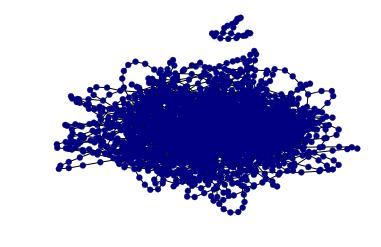

In [20]:
plotNetwork(G_bus, [0]*len(nodes),pos=spring_pos)

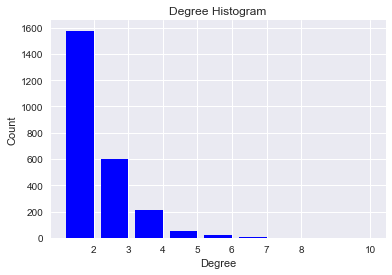

In [21]:
# Nodes degree histogram
degree_sequence = sorted([d for n, d in G_bus.degree()], reverse=True)  # degree sequence
# print "Degree sequence", degree_sequence
degreeCount = collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())

fig, ax = plt.subplots()
plt.bar(deg, cnt, width=0.80, color='b')

plt.title("Degree Histogram")
plt.ylabel("Count")
plt.xlabel("Degree")
ax.set_xticks([d + 0.4 for d in deg])
ax.set_xticklabels(deg)
plt.show()

In [22]:
# Degree per node
nodes_degrees = [0]*len(nodes)
for idx, n in enumerate(nodes):
    nodes_degrees [idx] = G_bus.degree(n)

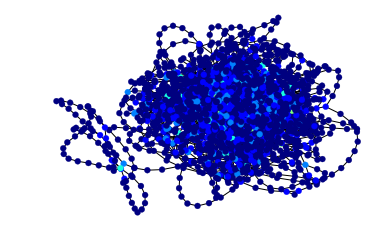

In [23]:
plotNetwork(G_bus, nodes_degrees)

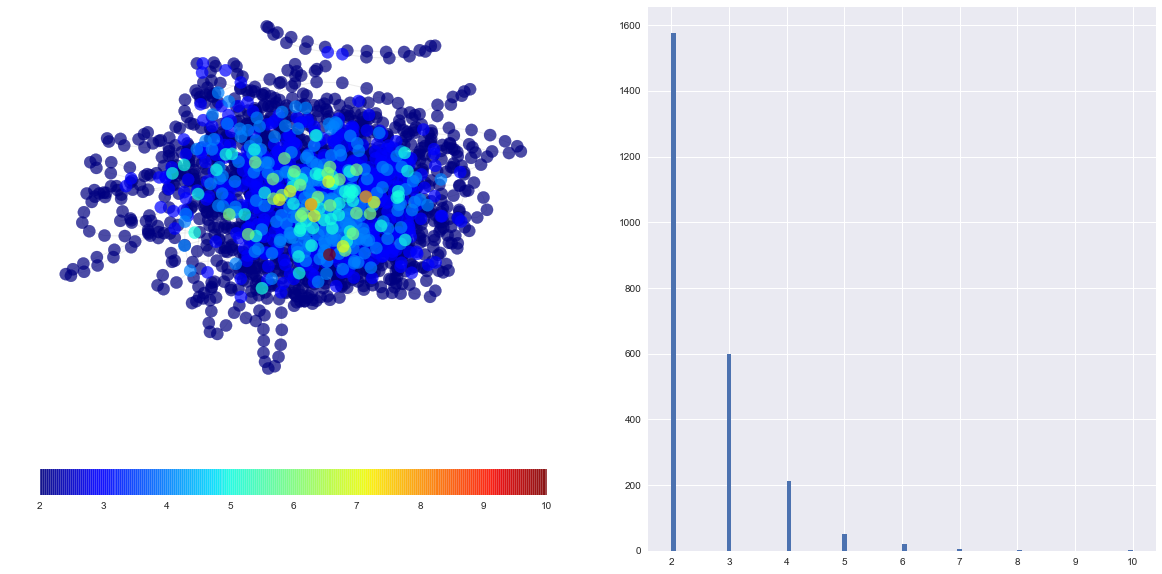

In [24]:
pos = nx.spring_layout(G_bus)
plt.figure(figsize=(20,10))

plt.subplot(121)
plt.axis('off')
nx.draw_networkx_edges(G_bus, pos=pos, edge_color='#c1c1c1', alpha=.3)
scores = dict(G_bus.degree)
nodelist = sorted(G_bus.nodes(), key=lambda n: scores[n])
ncolor = np.asarray([scores[n] for n in nodelist])
nodes = nx.draw_networkx_nodes(G_bus, nodelist=nodelist, pos=pos, node_size=150, cmap=plt.cm.jet, node_color=ncolor, alpha=0.7)
plt.colorbar(nodes, cmap=plt.cm.jet, orientation='horizontal')

plt.subplot(122)
score_array = np.array(list(scores.values()))
plt.hist(score_array,bins=100)
plt.show()

### Adjacency matrix

In [25]:
adjacency_matrix = nx.adjacency_matrix(G_bus, nodelist=None, weight='weight')

Largest eigenvalue: 3.81505097403
Smallest eigenvalue: -3.65499427858


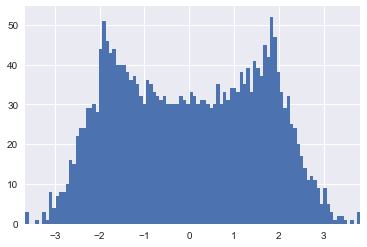

In [26]:
e = np.linalg.eigvals(adjacency_matrix.A)
print("Largest eigenvalue:", max(e))
print("Smallest eigenvalue:", min(e))
plt.hist(e, bins=100)  # histogram with 100 bins
plt.xlim(min(e), max(e))  # eigenvalues between min and max
plt.show()

## Laplacian matrix

Largest eigenvalue: 11.2733334299
Smallest eigenvalue: 0.0


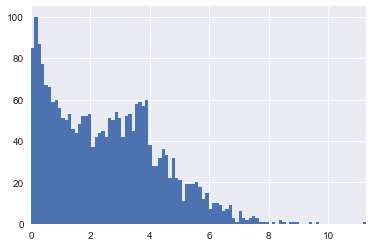

In [27]:
#laplacian_matrix = nx.laplacian_matrix(G_bus, nodelist=None, weight='weight')
#np.linalg.eig(laplacian_matrix.to_numpy_matrix())

laplacian_matrix = nx.laplacian_matrix(G_bus)
e = np.linalg.eigvals(laplacian_matrix.A)
print("Largest eigenvalue:", max(e))
print("Smallest eigenvalue:", min(e))
plt.hist(e, bins=100)  # histogram with 100 bins
plt.xlim(min(e), max(e))  # eigenvalues between min and max
plt.show()

### Centralities

In [28]:
#Degree centrality
degree_centrality = nx.degree_centrality(G_bus)

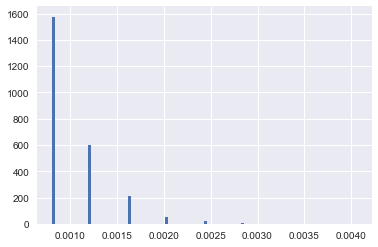

In [29]:
plt.hist(list(degree_centrality.values()), bins=100)  # histogram with 100 bins
plt.show()

In [30]:
max_degree_central_station = max(degree_centrality.items(), key=operator.itemgetter(1))
print(max_degree_central_station)
bus_stations_properties[max_degree_central_station[0]]

(777, 0.004051863857374392)


{'buses': '30 - 32 - 43 - 44 - 78 - 115',
 'city': 'BARCELONA',
 'furniture': 'Pal',
 'id': '777',
 'lat': '41.3805139',
 'lon': '2.1436483',
 'street_name': 'Av de Roma-Tarragona',
 'utm_x': '428486,2180',
 'utm_y': '4581552,6000'}

In [31]:
eigenvector_centrality = nx.eigenvector_centrality(G_bus, max_iter=10000, tol=1e-06, nstart=None, weight='weight')

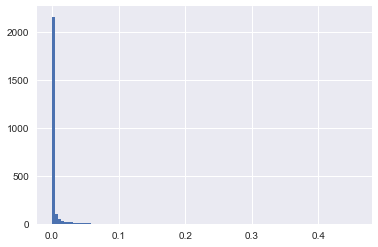

In [32]:
plt.hist(list(eigenvector_centrality.values()), bins=100)  # histogram with 100 bins
plt.show()

In [33]:
max_eigenvector_central_station = max(eigenvector_centrality.items(), key=operator.itemgetter(1))
print(max_eigenvector_central_station)
bus_stations_properties[max_eigenvector_central_station[0]]

(777, 0.456765123389888)


{'buses': '30 - 32 - 43 - 44 - 78 - 115',
 'city': 'BARCELONA',
 'furniture': 'Pal',
 'id': '777',
 'lat': '41.3805139',
 'lon': '2.1436483',
 'street_name': 'Av de Roma-Tarragona',
 'utm_x': '428486,2180',
 'utm_y': '4581552,6000'}

#### Closeness centrality

In [34]:
closeness_centrality = nx.closeness_centrality(G_bus)

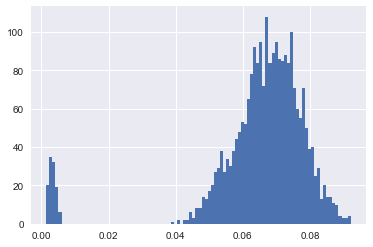

In [35]:
plt.hist(list(closeness_centrality.values()), bins=100)  # histogram with 100 bins
plt.show()

In [36]:
max_closeness_central_station = max(closeness_centrality.items(), key=operator.itemgetter(1))
print(max_closeness_central_station)
bus_stations_properties[max_closeness_central_station[0]]

(1209, 0.09206609595246185)


{'buses': '07 - 50 - 54 - 56 - 62 - 66 - 67 - 68',
 'city': 'BARCELONA',
 'furniture': 'Pal',
 'id': '1209',
 'lat': '41.3879730',
 'lon': '2.1664645',
 'street_name': 'Gran Via-Rambla Catalunya',
 'utm_x': '430401,3760',
 'utm_y': '4582362,7230'}

In [37]:
#d=nx.closeness_centrality(G)
#pos = nx.spring_layout(G_bus)
#ec = nx.draw_networkx_edges(G_bus, pos, alpha=0.05)
#nc = nx.draw_networkx_nodes(G_bus, pos, node_color=[v for v in closeness_centrality.values()], 
#                            with_labels=False, node_size=100, cmap=plt.cm.jet)
#plt.colorbar(nc)
#plt.axis('off')
#plt.show()

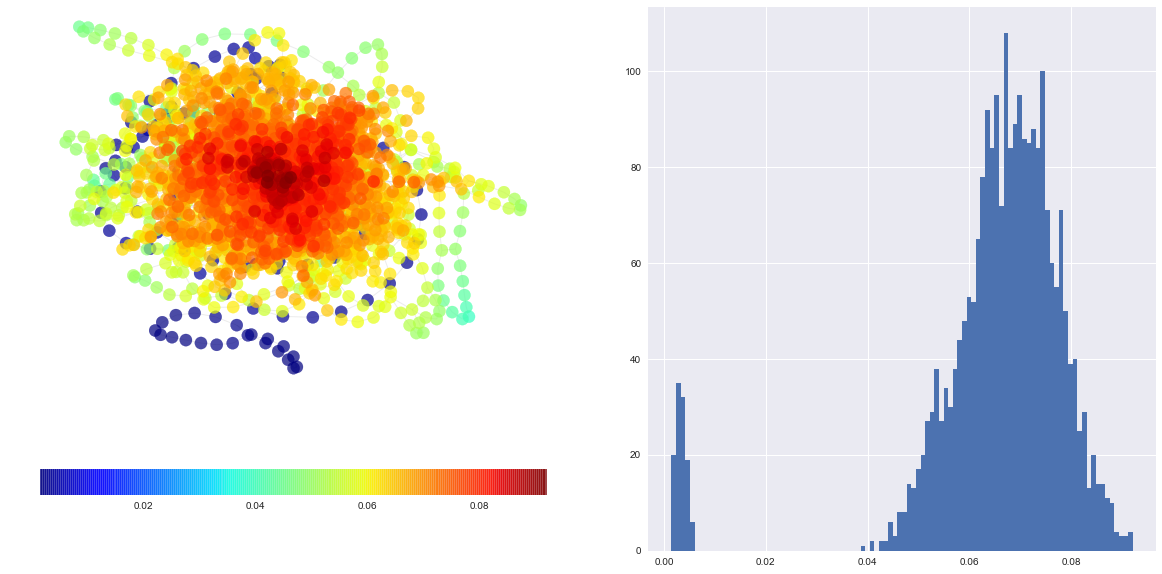

In [38]:
pos = nx.spring_layout(G_bus)
plt.figure(figsize=(20,10))

plt.subplot(121)
plt.axis('off')
nx.draw_networkx_edges(G_bus, pos=pos, edge_color='#c1c1c1', alpha=.3)
scores = dict(nx.closeness_centrality(G_bus))
nodelist = sorted(G_bus.nodes(), key=lambda n: scores[n])
ncolor = np.asarray([scores[n] for n in nodelist])
nodes = nx.draw_networkx_nodes(G_bus, nodelist=nodelist, pos=pos, node_size=150, cmap=plt.cm.jet, node_color=ncolor, alpha=0.7)
plt.colorbar(nodes, cmap=plt.cm.jet, orientation='horizontal')

plt.subplot(122)
score_array = np.array(list(scores.values()))
plt.hist(score_array,bins=100)
plt.show()

#### Betwenness centrality

In [26]:
betweenness_centrality_source = nx.betweenness_centrality_source(G_bus)

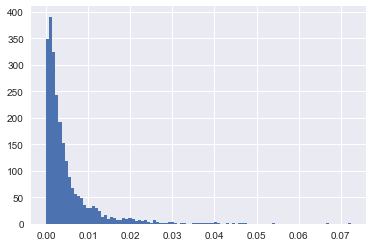

In [27]:
plt.hist(list(betweenness_centrality_source.values()), bins=100)  # histogram with 100 bins
plt.show()

In [28]:
max_betweeness_central_station = max(betweenness_centrality_source.items(), key=operator.itemgetter(1))
print(max_betweeness_central_station)
bus_stations_properties[max_betweeness_central_station[0]]

(21, 0.07239136501852589)


{'buses': '07 - 33 - 67 - 74 - 75 - 113 - L14 - N12 - L79',
 'city': 'BARCELONA',
 'furniture': 'Marquesina',
 'id': '21',
 'lat': '41.3856356',
 'lon': '2.1161664',
 'street_name': 'Av Diagonal-Palau Reial',
 'utm_x': '426194,0333',
 'utm_y': '4582144,2737'}

In [29]:
#bc=nx.betweenness_centrality(G)
#ec = nx.draw_networkx_edges(G_bus, pos, alpha=0.05)
#nc = nx.draw_networkx_nodes(G_bus, pos, node_color=[v for v in betweenness_centrality_source.values()], 
#                            with_labels=False, node_size=100,cmap=plt.cm.jet)
#plt.colorbar(nc)
#plt.axis('off')
#plt.show()

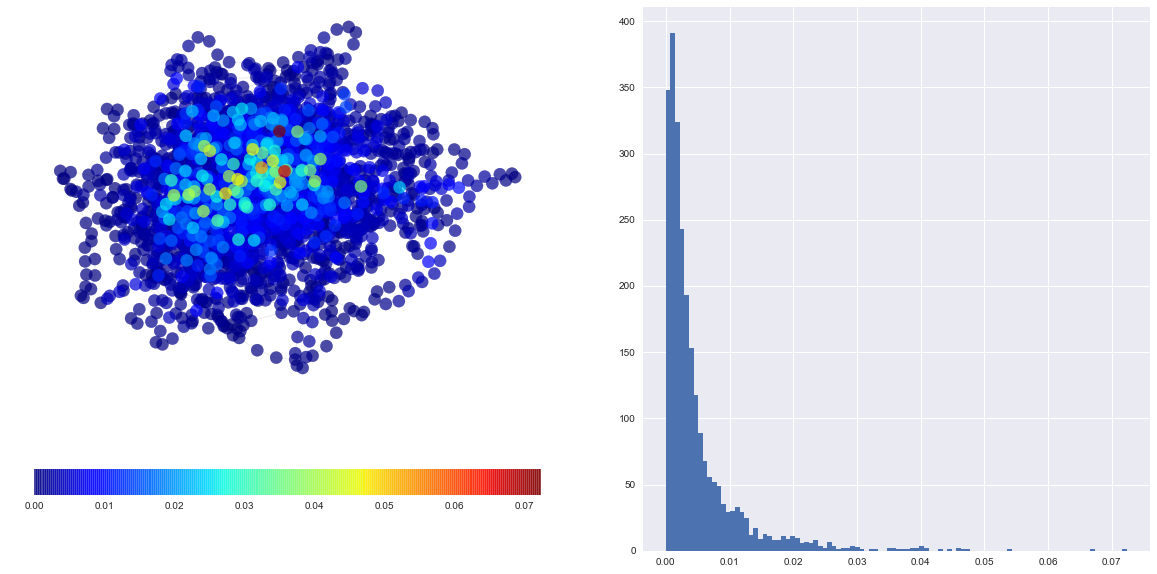

In [30]:
plt.figure(figsize=(20,10))

plt.subplot(121)
plt.axis('off')
nx.draw_networkx_edges(G_bus, pos=pos, edge_color='#c1c1c1', alpha=.3)
scores = dict(betweenness_centrality_source)
nodelist = sorted(G_bus.nodes(), key=lambda n: scores[n])
ncolor = np.asarray([scores[n] for n in nodelist])
nodes = nx.draw_networkx_nodes(G_bus, nodelist=nodelist, pos=pos, node_size=150, cmap=plt.cm.jet, node_color=ncolor, alpha=0.7)
plt.colorbar(nodes, cmap=plt.cm.jet, orientation='horizontal')

plt.subplot(122)
score_array = np.array(list(scores.values()))
plt.hist(score_array,bins=100)
plt.show()

In [ ]:
# Mirar relación entre medidas de centralidad. Esperamos que todo esté alrededor de la diagonal

#  --------- Others --------- 

## Community Detection

In [45]:
communities_generator = community.girvan_newman(G_bus)
top_level_communities = next(communities_generator)
next_level_communities = next(communities_generator)
parts = sorted(map(sorted, next_level_communities))

In [46]:
node_communities = [0]*len(nodes)
for idx,c in enumerate(parts):
    for n in c:
        node_communities[nodes.index(n)] = idx
     

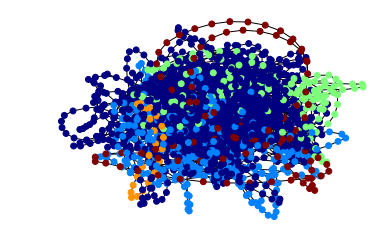

In [47]:
plotNetwork(G_bus,node_communities)

In [21]:
help(community)

Help on package networkx.algorithms.community in networkx.algorithms:

NAME
    networkx.algorithms.community - Functions for computing and measuring community structure.

DESCRIPTION
    The functions in this class are not imported into the top-level
    :mod:`networkx` namespace. You can access these functions by importing
    the :mod:`networkx.algorithms.community` module, then accessing the
    functions as attributes of ``community``. For example::
    
        >>> import networkx as nx
        >>> from networkx.algorithms import community
        >>> G = nx.barbell_graph(5, 1)
        >>> communities_generator = community.girvan_newman(G)
        >>> top_level_communities = next(communities_generator)
        >>> next_level_communities = next(communities_generator)
        >>> sorted(map(sorted, next_level_communities))
        [[0, 1, 2, 3, 4], [5], [6, 7, 8, 9, 10]]

PACKAGE CONTENTS
    asyn_fluidc
    centrality
    community_generators
    community_utils
    kclique
    ke